In [1]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
import pickle as pkl
from typing import List
from collections import Counter
import torch
from torch_geometric.utils.convert import to_networkx, from_networkx
import gc; gc.enable();

# Preprocessing

In [2]:
df = pd.read_pickle("metadata.pkl")

In [9]:
df["title"] = df["title"].apply(lambda x: BeautifulSoup(str(x).lower(), "lxml").text)

/tmp/ipykernel_5802/3788218982.py:1: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["title"] = df["title"].apply(lambda x: BeautifulSoup(str(x).lower(), "lxml").text)


In [10]:
df["abstract"] = df["abstract"].apply(lambda x: BeautifulSoup(str(x).lower(), "lxml").text)

/tmp/ipykernel_5802/4135695934.py:1: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["abstract"] = df["abstract"].apply(lambda x: BeautifulSoup(str(x).lower(), "lxml").text)


In [31]:
repeated_titles = (df["title"].value_counts() > 1).to_frame()
repeated_titles = list(repeated_titles[repeated_titles["count"]].reset_index(drop=False)["title"].values)
repeated_titles

['nan',
 'erratum',
 'errata',
 'preface',
 'introduction',
 'editorial',
 'discussion',
 'foreword',
 'advances in chemical physics',
 'quantum mechanics',
 'planck2015 results',
 'article',
 'planckintermediate results',
 'front cover',
 'atomic data from the iron project',
 'general discussion',
 'superconductivity',
 'quasicrystals',
 'the amateur scientist',
 'addendum',
 'dielectronic recombination data for dynamic finite-density plasmas',
 'liquid crystals',
 'carbon nanotubes',
 'corrigendum',
 'partial differential equations',
 'theory of superconductivity',
 'correspondence',
 'editorial: promoting inclusive and respectful communications',
 'stochastic differential equations',
 'erratum notice',
 'quantum field theory',
 'table of contents',
 'review of particle properties',
 'studies in protein metabolism',
 'mathematical games',
 'quantum computing',
 'double beta decay',
 'full length article',
 'statistical mechanics',
 'the vimos public extragalactic redshift survey (vip

In [32]:
len(repeated_titles)

16858

In [33]:
repeated_dois = (df["doi"].value_counts() > 1).to_frame()
repeated_dois = list(repeated_dois[repeated_dois["count"]].reset_index(drop=False)["doi"].values)
repeated_dois

['https://doi.org/10.1126/science',
 'https://doi.org/10.1103/physreva.41.5243',
 'https://doi.org/10.1051/0004-6361/201322780',
 'https://doi.org/10.1103/physrevlett.72.1572',
 'https://doi.org/10.1103/physreva.51.3534',
 'https://doi.org/10.1051/0004-6361/201015844',
 'https://doi.org/10.1103/physrevlett.97.202003',
 'https://doi.org/10.1051/0004-6361/201219398',
 'https://doi.org/10.1242/jeb.47.2.267',
 'https://doi.org/10.1103/physrevb.49.13075',
 'https://doi.org/10.1093/bioinformatics/btr602',
 'https://doi.org/10.1242/jeb.199.1.129',
 'https://doi.org/10.12942/lrr-2003-4',
 'https://doi.org/10.1103/physreva.42.5763',
 'https://doi.org/10.1051/0004-6361/201425301',
 'https://doi.org/10.1051/0004-6361/200913565',
 'https://doi.org/10.1103/physreva.73.063622',
 'https://doi.org/10.1038/nmat2325',
 'https://doi.org/10.1103/physrevb.44.5299',
 'https://doi.org/10.1016/j.nuclphysbps.2011.06.021',
 'https://doi.org/10.1103/physrevd.92.055004',
 'https://doi.org/10.1086/307363',
 'https

In [34]:
df = df[~df["title"].isin(repeated_titles)]
df = df[~df["doi"].isin(repeated_dois)].reset_index(drop=True)

In [4]:
df["high_confidence_concept"] = df["concepts"].apply(lambda x: (eval(x)[0][1] > 0.95) if isinstance(x, str) else False)

In [9]:
df = df[(df["abstract"].notna()) & (df["title"].notna()) & (df["referenced_works_count"].notna())]

In [21]:
df["referenced_works_count"] = pd.to_numeric(df["referenced_works_count"], errors="coerce")

In [22]:
df = df[(df["abstract"].notna()) & (df["title"].notna()) & (df["referenced_works_count"].notna())]

In [23]:
df = df[df["referenced_works_count"].astype(int) > 0]

In [27]:
df["referenced_works_count"] = df["referenced_works_count"].astype("int32")

In [32]:
#df.to_pickle("metadata_full_filtered.pkl", compression={'method': 'gzip', 'compresslevel': 3, 'mtime': 1})

In [34]:
df

,doi,id,abstract,title,publication_date,type,type_crossref,keywords,first_author,all_authors,all_authors_af,language,referenced_works,referenced_works_count,related_works,concepts,is_accepted,is_published,high_confidence_concept
0,https://doi.org/10.1103/physrevlett.26.192,https://openalex.org/W2050313003,tunneling measurements on junctions between ve...,spin-dependent tunneling into ferromagnetic ni...,1971-01-25,article,journal-article,"['nickel', 'spin-dependent']",P. M. Tedrow,"['P. M. Tedrow', 'R. Meservey']","['Francis Bitter National Magnet Laboratory, M...",en,"['https://openalex.org/W1966010108', 'https://...",12,"['https://openalex.org/W1998765608', 'https://...","[('Condensed matter physics', 0.8544545), ('Qu...",False,False,False
1,https://doi.org/10.1103/physreve.92.012819,https://openalex.org/W1758342214,inspired by the fact that people have diverse ...,competition and cooperation among different pu...,2015-07-27,article,journal-article,"['different punishing strategies', 'competitio...",Xiaojie Chen,"['Xiaojie Chen', 'Attila Szolnoki', 'Matjaž Pe...","['School of Mathematical Sciences, University ...",en,"['https://openalex.org/W748497126', 'https://o...",43,"['https://openalex.org/W2996115615', 'https://...","[('Public goods game', 0.79590267), ('Competit...",False,False,False
2,https://doi.org/10.1103/physrev.123.968,https://openalex.org/W2040287172,the scattering matrix for compound nucleus pro...,theory of average neutron reaction cross secti...,1961-08-01,article,journal-article,"['cross sections', 'resonance']",P.A. Moldauer,['P.A. Moldauer'],"['Argonne National Laboratory, Argonne, Illino...",en,"['https://openalex.org/W1965366397', 'https://...",19,"['https://openalex.org/W2063585241', 'https://...","[('Physics', 0.75732374), ('Resonance (particl...",False,False,False
3,https://doi.org/10.1103/physrevlett.86.4536,https://openalex.org/W1973501299,"the instability, dynamics, and morphological t...",templating of thin films induced by dewetting ...,2001-05-14,article,journal-article,"['thin films', 'surfaces']",Kajari Kargupta,"['Kajari Kargupta', 'Ashutosh Sharma']","['Department of Chemical Engineering, Indian I...",en,"['https://openalex.org/W1514074674', 'https://...",23,"['https://openalex.org/W2236704256', 'https://...","[('Dewetting', 0.96603024), ('Instability', 0....",False,False,True
4,https://doi.org/10.1103/physrevlett.105.235502,https://openalex.org/W1535924615,the energy of arbitrary graphene edge is deriv...,graphene edge from armchair to zigzag: the ori...,2010-12-03,article,journal-article,"['nanotube chirality', 'graphene', 'edge']",Yuanyue Liu,"['Yuanyue Liu', 'Alex Dobrinsky', 'Boris I. Ya...",['Department of Mechanical Engineering & Mater...,en,"['https://openalex.org/W1992192511', 'https://...",25,"['https://openalex.org/W2318938206', 'https://...","[('Zigzag', 0.89218235), ('Graphene', 0.879921...",False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059783,https://doi.org/10.1016/s0921-4526(99)02691-5,https://openalex.org/W2045889366,few genuine organic bulk-ferromagnets have bee...,pressure-induced enhancement of tc in a genuin...,2000-07-01,article,journal-article,"['tc', 'pressure-induced', 'bulk-ferromagnet']",M Mito,"['M Mito', 'T Kawae', 'A Ikegami', 'M Hitaka',...","['Faculty of Engineering, Kyushu University, H...",en,"['https://openalex.org/W1972185364', 'https://...",6,"['https://openalex.org/W1802184100', 'https://...","[('Ferromagnetism', 0.9173384), ('Antiferromag...",False,False,False
2059784,https://doi.org/10.1159/000077866,https://openalex.org/W2077739444,flagella are extremely effective organelles of...,dual flagellar systems enable motility under d...,2004-01-01,article,journal-article,"['motility', 'systems']",Linda L. McCarter,['Linda L. McCarter'],"['Department of Microbiology, The University o...",en,"['https://openalex.org/W1978139448', 'https://...",7,"['https://openalex.org/W2160068301', 'https://...","[('Flagell

# EDA

In [10]:
df = pd.read_pickle("metadata_full_filtered.pkl")

<Axes: xlabel='publication_date'>

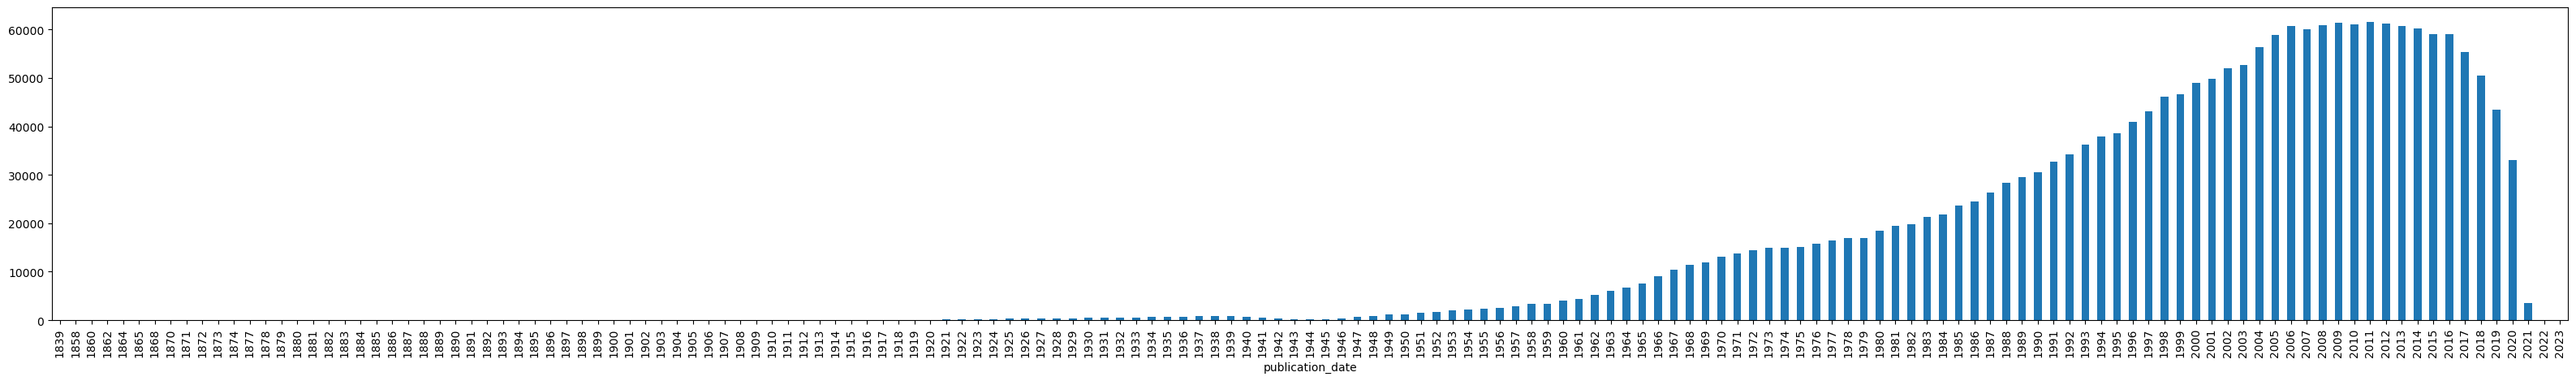

In [3]:
df["publication_date"].apply(lambda x: x[:4]).value_counts().sort_index().plot.bar(figsize=(40,5))

In [4]:
len(df[df["high_confidence_concept"]]) / len(df)

0.07843234352273147

/home/vmachado/anaconda3/envs/dl_ds_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vmachado/anaconda3/envs/dl_ds_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 0, 'Log scale Node degree'),
 Text(0, 0.5, 'Log scale count of Nodes')]

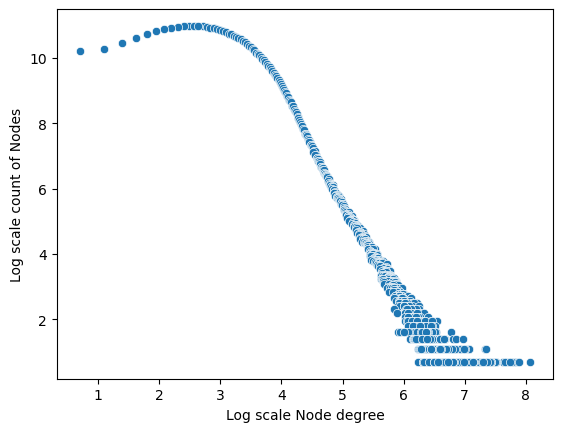

In [26]:
count = df["referenced_works_count"].value_counts().to_dict()
ax = sns.scatterplot(x=np.log1p(np.array(list(count.keys()))), y=np.log1p(np.array(list(count.values()))))
ax.set(xlabel="Log scale Node degree", ylabel="Log scale count of Nodes")

In [8]:
100 * df["language"].value_counts() / len(df)

language
en       99.462032
fr        0.292117
de        0.217255
it        0.003398
es        0.003107
ro        0.002573
ca        0.001893
ru        0.001602
pt        0.001359
et        0.000631
sv        0.000583
uk        0.000583
ja        0.000583
no        0.000534
tl        0.000388
vi        0.000340
nl        0.000340
da        0.000291
so        0.000243
cy        0.000243
af        0.000194
tr        0.000146
hu        0.000097
ko        0.000097
hr        0.000097
zh-cn     0.000049
pl        0.000049
sl        0.000049
id        0.000049
Name: count, dtype: float64

In [3]:
df

,doi,id,abstract,title,publication_date,type,type_crossref,keywords,first_author,all_authors,all_authors_af,language,referenced_works,referenced_works_count,related_works,concepts,is_accepted,is_published,high_confidence_concept
0,https://doi.org/10.1103/physrevlett.26.192,https://openalex.org/W2050313003,tunneling measurements on junctions between ve...,spin-dependent tunneling into ferromagnetic ni...,1971-01-25,article,journal-article,"['nickel', 'spin-dependent']",P. M. Tedrow,"['P. M. Tedrow', 'R. Meservey']","['Francis Bitter National Magnet Laboratory, M...",en,"['https://openalex.org/W1966010108', 'https://...",12,"['https://openalex.org/W1998765608', 'https://...","[('Condensed matter physics', 0.8544545), ('Qu...",False,False,False
1,https://doi.org/10.1103/physreve.92.012819,https://openalex.org/W1758342214,inspired by the fact that people have diverse ...,competition and cooperation among different pu...,2015-07-27,article,journal-article,"['different punishing strategies', 'competitio...",Xiaojie Chen,"['Xiaojie Chen', 'Attila Szolnoki', 'Matjaž Pe...","['School of Mathematical Sciences, University ...",en,"['https://openalex.org/W748497126', 'https://o...",43,"['https://openalex.org/W2996115615', 'https://...","[('Public goods game', 0.79590267), ('Competit...",False,False,False
2,https://doi.org/10.1103/physrev.123.968,https://openalex.org/W2040287172,the scattering matrix for compound nucleus pro...,theory of average neutron reaction cross secti...,1961-08-01,article,journal-article,"['cross sections', 'resonance']",P.A. Moldauer,['P.A. Moldauer'],"['Argonne National Laboratory, Argonne, Illino...",en,"['https://openalex.org/W1965366397', 'https://...",19,"['https://openalex.org/W2063585241', 'https://...","[('Physics', 0.75732374), ('Resonance (particl...",False,False,False
3,https://doi.org/10.1103/physrevlett.86.4536,https://openalex.org/W1973501299,"the instability, dynamics, and morphological t...",templating of thin films induced by dewetting ...,2001-05-14,article,journal-article,"['thin films', 'surfaces']",Kajari Kargupta,"['Kajari Kargupta', 'Ashutosh Sharma']","['Department of Chemical Engineering, Indian I...",en,"['https://openalex.org/W1514074674', 'https://...",23,"['https://openalex.org/W2236704256', 'https://...","[('Dewetting', 0.96603024), ('Instability', 0....",False,False,True
4,https://doi.org/10.1103/physrevlett.105.235502,https://openalex.org/W1535924615,the energy of arbitrary graphene edge is deriv...,graphene edge from armchair to zigzag: the ori...,2010-12-03,article,journal-article,"['nanotube chirality', 'graphene', 'edge']",Yuanyue Liu,"['Yuanyue Liu', 'Alex Dobrinsky', 'Boris I. Ya...",['Department of Mechanical Engineering & Mater...,en,"['https://openalex.org/W1992192511', 'https://...",25,"['https://openalex.org/W2318938206', 'https://...","[('Zigzag', 0.89218235), ('Graphene', 0.879921...",False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059783,https://doi.org/10.1016/s0921-4526(99)02691-5,https://openalex.org/W2045889366,few genuine organic bulk-ferromagnets have bee...,pressure-induced enhancement of tc in a genuin...,2000-07-01,article,journal-article,"['tc', 'pressure-induced', 'bulk-ferromagnet']",M Mito,"['M Mito', 'T Kawae', 'A Ikegami', 'M Hitaka',...","['Faculty of Engineering, Kyushu University, H...",en,"['https://openalex.org/W1972185364', 'https://...",6,"['https://openalex.org/W1802184100', 'https://...","[('Ferromagnetism', 0.9173384), ('Antiferromag...",False,False,False
2059784,https://doi.org/10.1159/000077866,https://openalex.org/W2077739444,flagella are extremely effective organelles of...,dual flagellar systems enable motility under d...,2004-01-01,article,journal-article,"['motility', 'systems']",Linda L. McCarter,['Linda L. McCarter'],"['Department of Microbiology, The University o...",en,"['https://openalex.org/W1978139448', 'https://...",7,"['https://openalex.org/W2160068301', 'https://...","[('Flagell

# Network creation

## Construct filtered network (keep only english and nodes present in the dataset)

In [6]:
network = {}
degrees = []
df_en = df[df["language"] == "en"].reset_index(drop=True) 
all_nodes = set(df_en["id"].tolist())
for _, x in df_en.iterrows():
    id = x["id"]
    ref = x["referenced_works"]
    if isinstance(ref, str):
        ev = eval(ref)
        if isinstance(ev, List) and len(ev) > 0:
            network[id] = set(ev).intersection(all_nodes)
            degrees.append((id, len(network[id])))
            
df = df[df["id"].isin(list(network.keys()))].reset_index(drop=True) 

In [7]:
len(network.keys())

2048707

## Droping unused/redundant columns for saving memory in future tasks

In [10]:
df = df.drop(columns=["doi", "type", "type_crossref", "first_author", "all_authors", "all_authors_af", "language", "referenced_works", "referenced_works_count", "related_works", "is_accepted", "is_published", "high_confidence_concept"])

In [14]:
df.to_pickle("df_en_minimal.pkl")

In [15]:
pkl.dump(network, open("network_filtered.pkl", "wb"))

In [2]:
df = pd.read_pickle("df_en_minimal.pkl")

In [3]:
df

,id,abstract,title,publication_date,keywords,concepts
0,https://openalex.org/W2050313003,tunneling measurements on junctions between ve...,spin-dependent tunneling into ferromagnetic ni...,1971-01-25,"['nickel', 'spin-dependent']","[('Condensed matter physics', 0.8544545), ('Qu..."
1,https://openalex.org/W1758342214,inspired by the fact that people have diverse ...,competition and cooperation among different pu...,2015-07-27,"['different punishing strategies', 'competitio...","[('Public goods game', 0.79590267), ('Competit..."
2,https://openalex.org/W2040287172,the scattering matrix for compound nucleus pro...,theory of average neutron reaction cross secti...,1961-08-01,"['cross sections', 'resonance']","[('Physics', 0.75732374), ('Resonance (particl..."
3,https://openalex.org/W1973501299,"the instability, dynamics, and morphological t...",templating of thin films induced by dewetting ...,2001-05-14,"['thin films', 'surfaces']","[('Dewetting', 0.96603024), ('Instability', 0...."
4,https://openalex.org/W1535924615,the energy of arbitrary graphene edge is deriv...,graphene edge from armchair to zigzag: the ori...,2010-12-03,"['nanotube chirality', 'graphene', 'edge']","[('Zigzag', 0.89218235), ('Graphene', 0.879921..."
...,...,...,...,...,...,...
2048702,https://openalex.org/W2045889366,few genuine organic bulk-ferromagnets have bee...,pressure-induced enhancement of tc in a genuin...,2000-07-01,"['tc', 'pressure-induced', 'bulk-ferromagnet']","[('Ferromagnetism', 0.9173384), ('Antiferromag..."
2048703,https://openalex.org/W2077739444,flagella are extremely effective organelles of...,dual flagellar systems enable motility under d...,2004-01-01,"['motility', 'systems']","[('Flagellum', 0.9636199), ('Cell biology', 0...."
2048704,https://openalex.org/W2051978307,we observed that high-power pulsed magnetron p...,instabilities in high-power impulse magnetron ...,2013-02-01,"['stochasticity', 'high-power']","[('Impulse (physics)', 0.7184582), ('Plasma', ..."
2048705,https://openalex.org/W2068379212,the specific mass shift contribution to the is...,many-body calculations of atomic isotope shifts,1985-09-14,"['shifts', 'many-body']","[('Atomic physics', 0.63052225), ('Isotope', 0..."


In [15]:
network = pkl.load(open("network_filtered.pkl", "rb"))

## New graph distribution indicates that it have power-law graphs characteristics (good for optimization tasks, bad for modularity objective)

/home/vmachado/anaconda3/envs/dl_ds_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vmachado/anaconda3/envs/dl_ds_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 0, 'Log scale Node degree'),
 Text(0, 0.5, 'Log scale count of Nodes')]

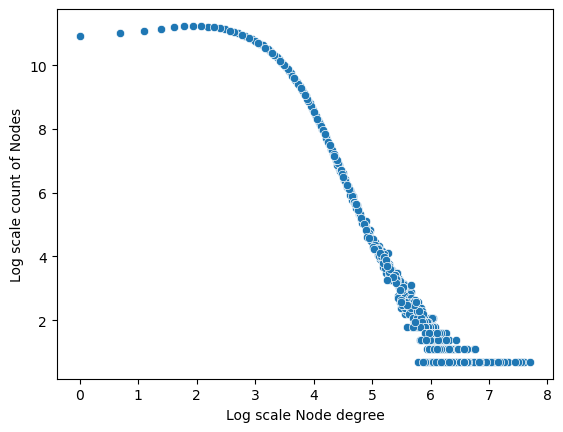

In [7]:
degrees = [len(v) for k,v in network.items()]
counts = Counter(degrees)

#display(count)
ax = sns.scatterplot(x=np.log1p(np.array(list(counts.keys()))), y=np.log1p(np.array(list(counts.values()))))
ax.set(xlabel="Log scale Node degree", ylabel="Log scale count of Nodes")
#plt.show()

## Construct networkx graph for converting to edge indices

In [8]:
g = nx.Graph(network)

In [4]:
df = df.sort_values("id").reset_index(drop=True) #.set_index("id") #.loc['https://openalex.org/W2050313003']
df

,id,abstract,title,publication_date,keywords,concepts
0,https://openalex.org/W100001730,the raman spectra of the parent compound naxco...,raman spectroscopy study ofnaxcoo2and supercon...,2004-08-10,"['raman spectroscopy', 'spectroscopy study']","[('Raman spectroscopy', 0.89063823), ('Superco..."
1,https://openalex.org/W1000042173,publisher summary this chapter discusses the s...,chapter 1: vortices in rotating superfluid3he,1986-01-01,"['superfluid3he', 'vortices']","[('Vortex', 0.7865634), ('Physics', 0.376391),..."
2,https://openalex.org/W100006313,in a wire spark-chamber experiment the squared...,experimental study on the τ± decay matrix element,1972-03-01,['matrix'],"[('Physics', 0.9268166), ('Matrix element', 0...."
3,https://openalex.org/W1000096099,"using angle-resolved photoemission, we have ma...",fermi surface and electronic structure ofnd2−xce,1993-05-17,"['fermi surface', 'electronic structure']","[('Fermi surface', 0.59463906), ('Physics', 0...."
4,https://openalex.org/W1000312985,we demonstrate controlled manipulation of larg...,microparticle manipulation using inertial forces,2006-02-27,"['forces', 'manipulation']","[('Particle (ecology)', 0.62976944), ('Micropa..."
...,...,...,...,...,...,...
2048702,https://openalex.org/W999422512,a mostly single bcc phase with nanoscale grain...,high saturation magnetization and soft magneti...,1991-01-01,"['soft magnetic properties', 'high saturation ...","[('Materials science', 0.725253), ('Amorphous ..."
2048703,https://openalex.org/W999575332,publisher summary this chapter discusses a phe...,chapter 1 protein-lipid interactions and membr...,1993-01-01,"['membrane heterogeneity', 'protein-lipid']","[('Chemistry', 0.4417297), ('Biology', 0.38962..."
2048704,https://openalex.org/W99994197,measurements are reported of the transmission ...,infrared optical excitations inla2nio4,1995-10-01,['infrared optical excitations'],"[('Physics', 0.62062633), ('Absorption (acoust..."
2048705,https://openalex.org/W999961912,this chapter reviews the computational methods...,energies and asymptotic analysis for helium ry...,1993-01-01,['asymptotic analysis'],"[('Physics', 0.88181573), ('Rydberg formula', ..."


In [60]:
df.to_pickle("df_en_sorted_minimal.pkl")

## Sort graph nodes to indices correspond to sorted dataframe when generating edge indices

In [12]:
df = pd.read_pickle("df_en_sorted_minimal.pkl")
df

,id,abstract,title,publication_date,keywords,concepts
0,https://openalex.org/W100001730,the raman spectra of the parent compound naxco...,raman spectroscopy study ofnaxcoo2and supercon...,2004-08-10,"['raman spectroscopy', 'spectroscopy study']","[('Raman spectroscopy', 0.89063823), ('Superco..."
1,https://openalex.org/W1000042173,publisher summary this chapter discusses the s...,chapter 1: vortices in rotating superfluid3he,1986-01-01,"['superfluid3he', 'vortices']","[('Vortex', 0.7865634), ('Physics', 0.376391),..."
2,https://openalex.org/W100006313,in a wire spark-chamber experiment the squared...,experimental study on the τ± decay matrix element,1972-03-01,['matrix'],"[('Physics', 0.9268166), ('Matrix element', 0...."
3,https://openalex.org/W1000096099,"using angle-resolved photoemission, we have ma...",fermi surface and electronic structure ofnd2−xce,1993-05-17,"['fermi surface', 'electronic structure']","[('Fermi surface', 0.59463906), ('Physics', 0...."
4,https://openalex.org/W1000312985,we demonstrate controlled manipulation of larg...,microparticle manipulation using inertial forces,2006-02-27,"['forces', 'manipulation']","[('Particle (ecology)', 0.62976944), ('Micropa..."
...,...,...,...,...,...,...
2048702,https://openalex.org/W999422512,a mostly single bcc phase with nanoscale grain...,high saturation magnetization and soft magneti...,1991-01-01,"['soft magnetic properties', 'high saturation ...","[('Materials science', 0.725253), ('Amorphous ..."
2048703,https://openalex.org/W999575332,publisher summary this chapter discusses a phe...,chapter 1 protein-lipid interactions and membr...,1993-01-01,"['membrane heterogeneity', 'protein-lipid']","[('Chemistry', 0.4417297), ('Biology', 0.38962..."
2048704,https://openalex.org/W99994197,measurements are reported of the transmission ...,infrared optical excitations inla2nio4,1995-10-01,['infrared optical excitations'],"[('Physics', 0.62062633), ('Absorption (acoust..."
2048705,https://openalex.org/W999961912,this chapter reviews the computational methods...,energies and asymptotic analysis for helium ry...,1993-01-01,['asymptotic analysis'],"[('Physics', 0.88181573), ('Rydberg formula', ..."


In [21]:
H = nx.Graph()
H.add_nodes_from(sorted(g.nodes(data=True)))
H.add_edges_from(g.edges(data=True))

In [22]:
dataset = from_networkx(H)
torch.save(dataset, "torch_geometric_ds.bin")

In [13]:
dataset = torch.load("torch_geometric_ds.bin")

In [14]:
gc.collect()

1000

### Verify if edge indices are coherent

In [26]:
node_index_0_edges = sorted(dataset.edge_index[:, :33].flatten().unique().numpy())[1:]

In [24]:
network["https://openalex.org/W100001730"] # first dataframe entry, should correspond to the smallest index of edge_indices

{'https://openalex.org/W1664331607',
 'https://openalex.org/W1853787478',
 'https://openalex.org/W1976257635',
 'https://openalex.org/W1985213701',
 'https://openalex.org/W1988657733',
 'https://openalex.org/W2004246665',
 'https://openalex.org/W2016782453',
 'https://openalex.org/W2036732517',
 'https://openalex.org/W2040763157',
 'https://openalex.org/W2083317673',
 'https://openalex.org/W2135304848',
 'https://openalex.org/W3101361218',
 'https://openalex.org/W3105986726'}

In [29]:
# All nodes present in the original node 0 adjacency list are present in edge_indices, with the addition of some as we are considering a undirect graph for simplicity
# (it would be better to have both)
network["https://openalex.org/W100001730"].intersection(set(df.iloc[node_index_0_edges]["id"].values)) == network["https://openalex.org/W100001730"]

True